In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import keras_tuner as kt

In [2]:
data = pd.read_csv('DataIteration.csv')
data.head()

,Action,org:resource,concept:name,EventOrigin,lifecycle:transition,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,iteration
0,Created,User_1,A_Create Application,Application,complete,Existing loan takeover,New credit,Application_652823628,20000.0,20000.0,44.0,True,498.29,True,979.0,20000.0,Offer_148581083,1
1,statechange,User_1,A_Submitted,Application,complete,Existing loan takeover,New credit,Application_652823628,20000.0,20000.0,44.0,True,498.29,True,979.0,20000.0,Offer_148581083,1
2,Created,User_1,W_Handle leads,Workflow,schedule,Existing loan takeover,New credit,Application_652823628,20000.0,20000.0,44.0,True,498.29,True,979.0,20000.0,Offer_148581083,1
3,Deleted,User_1,W_Handle leads,Workflow,withdraw,Existing loan takeover,New credit,Application_652823628,20000.0,20000.0,44.0,True,498.29,True,979.0,20000.0,Offer_148581083,2
4,Created,User_1,W_Complete application,Workflow,schedule,Existing loan takeover,New credit,Application_652823628,20000.0,20000.0,44.0,True,498.29,True,979.0,20000.0,Offer_148581083,1


In [3]:
data.nunique()

Action                       5
org:resource               149
concept:name                26
EventOrigin                  3
lifecycle:transition         7
case:LoanGoal               14
case:ApplicationType         2
case:concept:name        31509
case:RequestedAmount       701
FirstWithdrawalAmount     5930
NumberOfTerms              147
Accepted                     2
MonthlyCost               5816
Selected                     2
CreditScore                520
OfferedAmount              663
OfferID                  42995
iteration                  123
dtype: int64

In [4]:
data['lifecycle:transition'].unique()

array(['complete', 'schedule', 'withdraw', 'start', 'suspend',
       'ate_abort', 'resume'], dtype=object)

In [5]:
np.where(data['lifecycle:transition'] == 'ate_abort')

(array([     12,      19,      25, ..., 1202232, 1202245, 1202262]),)

In [6]:
#target = np.where((data['lifecycle:transition'] == 'ate_abort') | (data['iteration'] >= 3),1,0)

#target = target
target1 = data['lifecycle:transition'].shift(1)
target2 = data["iteration"].shift(1)
target_1 = np.where((target1 == 'ate_abort') | (target2 >= 3),1,0)

target1 = data['lifecycle:transition'].shift(2)
target2 = data["iteration"].shift(2)
target_2 = np.where((target1 == 'ate_abort') | (target2 >= 3),1,0)

In [8]:
def encode(db):
    dtypes = list(zip(db.dtypes.index, map(str, db.dtypes)))
    for k,dtype in dtypes:
        if dtype == 'object':
            db[k] = LabelEncoder().fit_transform(db[k])
    return db.astype('float')

In [9]:
data = encode(data)

In [10]:
target = np.where(( data['lifecycle:transition'] == 'ate_abort') | (data["iteration"] >= 3),1,0)

In [11]:
iter = data.pop("iteration")

In [12]:
x_train, x_test, y_train, y_test = train_test_split(data,target,train_size=0.8,shuffle=False)

In [13]:
x_train.shape

(961813, 17)

In [14]:
x_train.head()

,Action,org:resource,concept:name,EventOrigin,lifecycle:transition,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
0,0.0,0.0,4.0,0.0,1.0,5.0,1.0,25893.0,20000.0,20000.0,44.0,1.0,498.29,1.0,979.0,20000.0,10997.0
1,4.0,0.0,8.0,0.0,1.0,5.0,1.0,25893.0,20000.0,20000.0,44.0,1.0,498.29,1.0,979.0,20000.0,10997.0
2,0.0,0.0,22.0,2.0,3.0,5.0,1.0,25893.0,20000.0,20000.0,44.0,1.0,498.29,1.0,979.0,20000.0,10997.0
3,1.0,0.0,22.0,2.0,6.0,5.0,1.0,25893.0,20000.0,20000.0,44.0,1.0,498.29,1.0,979.0,20000.0,10997.0
4,0.0,0.0,21.0,2.0,3.0,5.0,1.0,25893.0,20000.0,20000.0,44.0,1.0,498.29,1.0,979.0,20000.0,10997.0


In [13]:
from tensorflow.keras.callbacks import EarlyStopping
early = EarlyStopping(min_delta = 0.001, patience=12, restore_best_weights=True)

In [16]:
data.shape

(1202267, 17)

In [22]:
def model_builder(hp):
  model = keras.Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units1 = hp.Int('units', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units', min_value=32, max_value=512, step=32)
  hp_units4 = hp.Int('units', min_value=32, max_value=512, step=32)
  hp_hidden_activation1 = hp.Choice('activition', values=['relu','tanh'])
  hp_hidden_activation2 = hp.Choice('activition', values=['relu','tanh'])
  hp_hidden_activation3 = hp.Choice('activition', values=['relu','tanh'])
  hp_hidden_activation4 = hp.Choice('activition', values=['relu','tanh'])
  hp_dense_activation = hp.Choice('activation', values=['softmax','sigmoid'])
  
  
  model.add(tf.keras.layers.Reshape((17,-1),input_shape=(17,)))
  model.add(layers.GRU(hp_units1,return_sequences=True))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(layers.SimpleRNN(hp_units2, return_sequences=True))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(layers.LSTM(hp_units3, return_sequences=True))
  model.add(layers.MaxPooling1D())
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.BatchNormalization())
      
  model.add(layers.Flatten())
  model.add(layers.Dense(hp_units4, activation=hp_hidden_activation4))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Dense(1,activation = hp_dense_activation))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

  return model

In [49]:
model = tf.keras.models.Sequential([
    # tf.keras.layers.Embedding(input_dim=961813, output_dim = 128, input_length=17),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Reshape((17,-1),input_shape=(17,)),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),    

    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(64,activation = 'relu'),

    tf.keras.layers.Dense(1, activation='sigmoid'),
])

/home/modzo/miniconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [50]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy']
             )

In [51]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)             │ (None, 17, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 17, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 17, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 17, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 17, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 17, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 17, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 17, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 17, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 17, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        34,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,745 (233.38 KB)

 Trainable params: 59,489 (232.38 KB)

 Non-trainable params: 256 (1.00 KB)

In [52]:
db = tf.reshape(data,(-1,17,1))

In [53]:
from tensorflow.keras.utils import to_categorical

# Convert integer labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=17)

In [54]:
x_train.index

Index([     0,      1,      2,      3,      4,      5,      6,      7,      8,
            9,
       ...
       961803, 961804, 961805, 961806, 961807, 961808, 961809, 961810, 961811,
       961812],
      dtype='int64', length=961813)

In [23]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='kt_lstm')

In [24]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [25]:
sm_train,sm_test,sy_train,sy_test = train_test_split(x_train,y_train,train_size=0.1,shuffle=False)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [26]:
tuner.search(sm_train, sy_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 14m 19s]
val_accuracy: 0.46426159143447876

Best val_accuracy So Far: 0.963351845741272
Total elapsed time: 03h 38m 21s


In [27]:
model_rnn= tuner.hypermodel.build(best_hps)

/home/modzo/miniconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
history = model_rnn.fit(x_train,y_train,
                    validation_split = 0.2,
                    batch_size=256,
                    epochs = 100,
                    callbacks=early,
                   )

Epoch 1/100
3006/3006 ━━━━━━━━━━━━━━━━━━━━ 142s 45ms/step - accuracy: 0.8821 - loss: 0.2795 - val_accuracy: 0.9439 - val_loss: 0.1483
Epoch 2/100
3006/3006 ━━━━━━━━━━━━━━━━━━━━ 137s 46ms/step - accuracy: 0.9497 - loss: 0.1334 - val_accuracy: 0.9460 - val_loss: 0.1367
Epoch 3/100
3006/3006 ━━━━━━━━━━━━━━━━━━━━ 139s 46ms/step - accuracy: 0.9504 - loss: 0.1304 - val_accuracy: 0.9461 - val_loss: 0.1334
Epoch 4/100
3006/3006 ━━━━━━━━━━━━━━━━━━━━ 134s 45ms/step - accuracy: 0.9511 - loss: 0.1252 - val_accuracy: 0.9468 - val_loss: 0.1218
Epoch 5/100
3006/3006 ━━━━━━━━━━━━━━━━━━━━ 138s 46ms/step - accuracy: 0.9506 - loss: 0.1195 - val_accuracy: 0.9469 - val_loss: 0.1190
Epoch 6/100
3006/3006 ━━━━━━━━━━━━━━━━━━━━ 133s 44ms/step - accuracy: 0.9511 - loss: 0.1177 - val_accuracy: 0.9470 - val_loss: 0.1187
Epoch 7/100
3006/3006 ━━━━━━━━━━━━━━━━━━━━ 139s 46ms/step - accuracy: 0.9515 - loss: 0.1157 - val_accuracy: 0.9466 - val_loss: 0.1221
Epoch 8/100
3006/3006 ━━━━━━━━━━━━━━━━━━━━ 139s 46ms/step - ac

In [30]:
model_rnn.save('Rnn_model_optimized.h5')

In [31]:
history_df = pd.DataFrame(history.history)

In [32]:
history_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.927503,0.185510,0.943851,0.148294
1,0.949789,0.132581,0.945993,0.136706
2,0.950654,0.128958,0.946128,0.133370
3,0.951095,0.123591,0.946788,0.121764
4,0.950975,0.118496,0.946902,0.118963


In [33]:
import matplotlib.pyplot as plt

<Axes: >

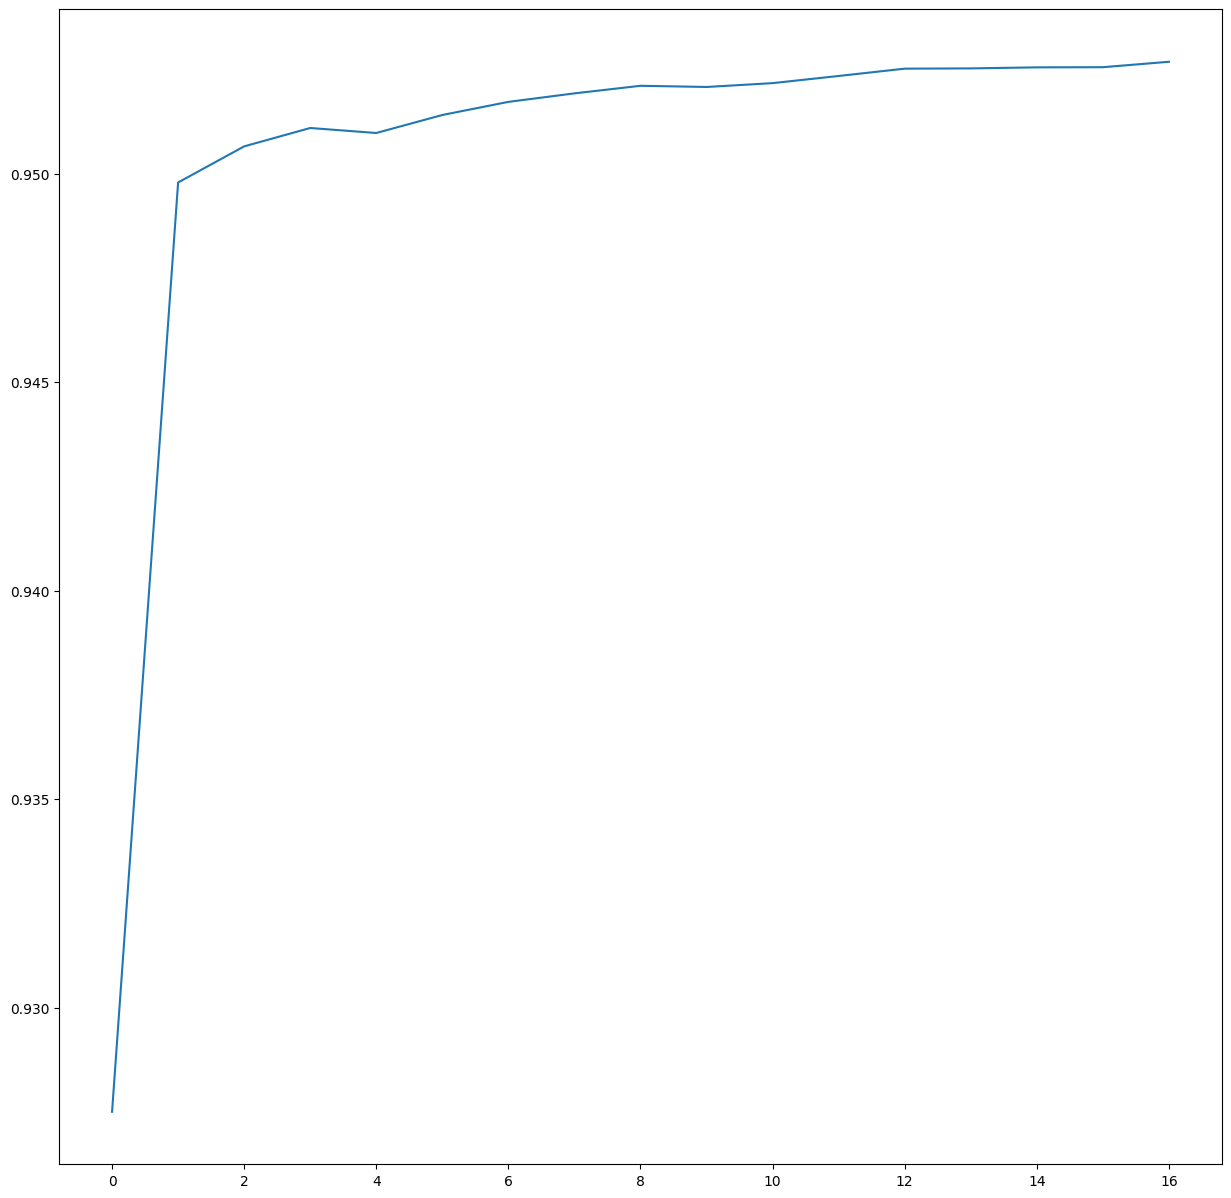

In [34]:
plt.figure(figsize=(15,15))
history_df['accuracy'].plot()

In [ ]:
# x_train.shape

In [ ]:
# input_shape = data.shape[0]

In [ ]:
# input_shape = (x_train.shape[0],xtrain.shape[1],1)
# model_cnn = tf.keras.models.Sequential([    
#     layers.Conv1D(filters=128, kernel_size=1, activation = 'relu', input_shape=input_shape),
#     layers.MaxPooling1D(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.BatchNormalization(),
    
# #     layers.Conv1D(64, 3, activation='relu'),
# #     layers.MaxPooling1D(),
# #     tf.keras.layers.Dropout(0.2),
# #     tf.keras.layers.BatchNormalization(),
    
# #     layers.Conv1D(32, 3, activation='relu'),
# #     layers.MaxPooling1D(),
# #     tf.keras.layers.Dropout(0.2),
# #     tf.keras.layers.BatchNormalization(),
        
# #     layers.Flatten(),
# #     layers.Dense(128, activation='relu'),
# #     tf.keras.layers.Dropout(0.2),
# #     tf.keras.layers.BatchNormalization(),
#     layers.Flatten(),
# #     tf.keras.layers.Dropout(0.2),
# #     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(1,activation = 'sigmoid')
# ])

In [ ]:
# # The inputs are 256-length vectors with 17 timesteps or features, and the batch size
# # is 4.
# input_shape = (1, 17, 256)
# x = tf.random.normal(input_shape)
# y = tf.keras.layers.Conv1D(
# 32, 3, activation='relu',input_shape=input_shape[1:])(x)
# print(y.shape)



In [ ]:
# input_shape = (1, 10, 128)
# x = tf.random.normal(input_shape)
# y = tf.keras.layers.Conv1D(
# 32, 3, activation='relu', input_shape=input_shape)(x)
# print(x[0][0])
# print(y.shape)

In [ ]:
# model_cnn.summary()

In [ ]:
#keras.utils.plot_model(model_cnn, show_shapes=True)

In [ ]:
# model_cnn.compile(optimizer='adam',
#               loss = tf.keras.losses.BinaryCrossentropy(),
#               metrics = ['accuracy']
#              )

In [ ]:
# x_test.shape

In [ ]:
# db = tf.reshape(data,(1, data.shape[1], -1))

In [ ]:
# train = tf.reshape(x_train,(-1, 17, 1))

In [ ]:
# test = tf.reshape(x_test,(-1,17,1))

In [ ]:
# train[0]

In [ ]:
# db[0],target[0]

In [ ]:
# t = tf.reshape(db,(-1,17,1))

In [ ]:
# t.shape

In [ ]:
# model_cnn(db)

In [ ]:
# train[0]

In [ ]:
# test[0]

In [ ]:
# input_shape = (train.shape[0],train.shape[1],1)

In [ ]:
# history1 = model_cnn.fit(train,y_train,
#                     validation_data=(test,y_test),
#                     epochs = 100,
#                     callbacks=early,
#                    )

In [ ]:
# history1_df = pd.DataFrame(history1.history)

In [ ]:
# plt.figure(figsize=(15,15))
# history1_df['accuracy'].plot()

In [ ]:
# model_cnn.save('Cnn_model.h5')